In [2]:
import re
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import shutil
import numpy as np
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
def plot_err(x_input, results, labels, xylabels, title=None, path=None, plottype=None):
    with PdfPages(f'{path}/{title.replace(" ", "_")}.pdf') as pdf:
        for i, (xaxis, result, label) in enumerate(zip(x_input, results, labels)):
            if plottype=='semilogx':
                plt.semilogx(xaxis, result, label=label, color=f'C{i}')
            elif plottype=='semilogy': 
                plt.semilogy(xaxis, result, label=label, color=f'C{i}')
            elif plottype=='loglog': 
                plt.loglog(xaxis, result, label=label, color=f'C{i}')
            else:
                if i==0:
                    plt.scatter(xaxis, result, label=label, s=100, color=f'C{i}', marker=r'$\clubsuit$')
                elif i>0:
                    index = np.argsort(xaxis).astype(int)
                    xaxis = [ xaxis[i] for i in index ]
                    result = [ result[i] for i in index ]
                    # print(f'index={index}')
                    plt.plot(xaxis, result, label=label, color=f'C{i}', marker='.')
                else:
                    plt.plot(xaxis, result, label=label, color=f'C{i}', marker='.')
        # if title:
        #     plt.title(title)
        plt.xlabel(xylabels[0])
        plt.ylabel(xylabels[1])
        plt.legend()
        plt.grid()
        if path:
            pdf.savefig()
        plt.show()

In [4]:
def extract_curve(file_path):
    file_target = open(file_path, 'r')
    perfs, fairs = np.empty([0]), np.empty([0])
    for i, line in enumerate(file_target):
        ls = line.strip('\n')
        if "- test acc:" in ls:
            break
        if "test acc" in ls:
            acc = re.findall(r"test acc:(.*)", ls)
            acc = np.float_(acc)
            perf = acc
            perfs = np.concatenate((perfs, perf))
        if "test D_SP" in ls:
            # D_SP = np.float_(re.findall(r"DP test:(.*)", ls)[0])
            D_SP = re.findall(r"test D_SP:(.*)", ls)
            fair = np.float_(D_SP)
            fairs = np.concatenate((fairs, fair))
    return perfs, fairs

def extract_perf(file_path):
    file_target = open(file_path, 'r')
    for i, line in enumerate(file_target):
        ls = line.strip('\n')
        if "Test statistics" in ls:
            if "acc" in ls:
                acc = re.findall(r"acc:(.*?)[,$]", ls)[0]
                acc = np.float_(acc.split('+-'))
                perf = acc
            elif "D_SP" in ls:
                D_SP = re.findall(r"D_SP:(.*)", ls)[0]
                D_SP = np.float_(D_SP.split('+-'))
                fair = D_SP
    return perf, fair

In [6]:
file_path = f'./log/pokec_z/kernel/GAT/hyper=0.0-4.log'
perf, fair = extract_perf(file_path)
perf 

array([0.8817, 0.0049])

In [7]:
perf, fair = extract_curve(file_path)
perf

array([0.5257, 0.4573, 0.4708, 0.5416, 0.5294, 0.5383, 0.5774, 0.6056,
       0.5058, 0.4889, 0.5373, 0.6325, 0.6228, 0.5996, 0.6085, 0.6195,
       0.6487, 0.6445, 0.6041, 0.6085, 0.6488, 0.6725, 0.6552, 0.6494,
       0.6483, 0.6599, 0.6755, 0.6865, 0.6759, 0.6822, 0.6889, 0.6923,
       0.6858, 0.677 , 0.6877, 0.6969, 0.7144, 0.7228, 0.7258, 0.7248,
       0.7261, 0.7189, 0.7151, 0.7245, 0.7397, 0.7497, 0.7553, 0.7676,
       0.7687, 0.7697, 0.7742, 0.7811, 0.7869, 0.7955, 0.7969, 0.8023,
       0.8095, 0.8114, 0.8152, 0.8165, 0.819 , 0.8196, 0.8256, 0.8291,
       0.8275, 0.8343, 0.8313, 0.8346, 0.8341, 0.8396, 0.8408, 0.8398,
       0.8416, 0.8419, 0.8435, 0.8424, 0.8457, 0.8452, 0.8451, 0.8517,
       0.8503, 0.847 , 0.8554, 0.8562, 0.8554, 0.8542, 0.8556, 0.8552,
       0.8572, 0.8573, 0.8537, 0.8586, 0.8565, 0.8605, 0.8608, 0.8622,
       0.8615, 0.8627, 0.8604, 0.8623, 0.8635, 0.8603, 0.8635, 0.8642,
       0.8643, 0.868 , 0.8634, 0.8651, 0.867 , 0.8634, 0.8673, 0.8675,
      

In [8]:
def results_extract(method, dataset, model, alpha_vec=None, running_times=5):
    perfs, fairs = np.empty([0,2]), np.empty([0, 2])

    methods = ["kernel", "kernel_bn", "adv", "adv_bn"]
    
    if method in methods:
        index = methods.index(method)
        alphas = alpha_vec[index]
        for alpha in alphas:
            file_path = f'./log/{dataset}/{method}/{model}/hyper={alpha}-{running_times-1}.log'
            
            perf, fair = extract_perf(file_path)
            
            perfs = np.concatenate((perfs, np.expand_dims(perf, 0)))
            fairs = np.concatenate((fairs, np.expand_dims(fair, 0)))

    return perfs, fairs

In [9]:
def results_all(methods, dataset, model, alpha_vec=None, running_times=5):
    perfs, fairs = [], []
    for method in methods:
        perf, fair = results_extract(method, dataset, model, alpha_vec, running_times)
        perf, fair = list(perf[:,0]), list(fair[:,0])
        if method=="kernel":
            perfs.append(perf[0:1])
            fairs.append(fair[0:1])
        perfs.append(perf[1:])
        fairs.append(fair[1:])
    ### return len(methods) + 1
    return perfs, fairs

In [10]:
def plot_tradeoff(method_vec, dataset, model, alpha_vec):
    perfs, fairs = results_all(method_vec, dataset, model, alpha_vec)

    xaxis = fairs
    results = perfs
    labels = ['vanilla', 'kernel', 'kernel_bn', 'adv', 'adv_bn']
    xylabels = ['DP', 'Acc']
    title = f'{dataset}_{model}_tradeoff'
    path = 'results'

    plot_err(xaxis, results, labels, xylabels, title, path)

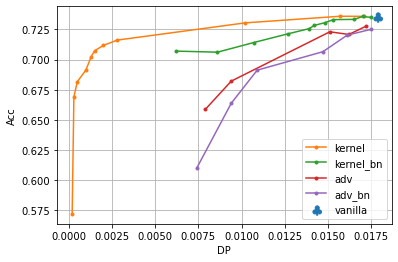

In [196]:
dataset = 'pokec_n'  ## 'pokec_n' 'pokec_z'
model = 'GCN' ## 'GAT', 'GCN'
method_vec = ['kernel', 'kernel_bn', 'adv', 'adv_bn']   ## 'kernel', 'kernel_bn', 'adv', 'adv_bn'
alpha_vec = [[0.0, 0.1, 0.3, 1.0, 3.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0],
            [0.0, 1.0, 3.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0, 1000.0, 2000.0],
            [0.0, 1.0, 10.0, 50.0, 500.0, 1000.0],
            [0.0, 1.0, 10.0, 50.0, 500.0, 1000.0, 2000.0]]
## kernel = [0.0, 1.0, 3.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0]
## adv = [0.0, 1.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 2000.0]

plot_tradeoff(method_vec, dataset, model, alpha_vec)

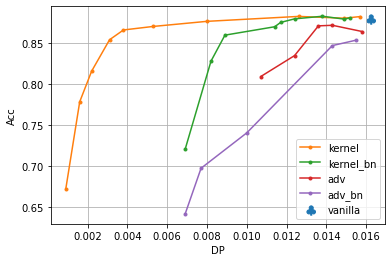

In [11]:
dataset = 'pokec_n'  ## 'pokec_n' 'pokec_z'
model = 'GAT' ## 'GAT', 'GCN'
method_vec = ['kernel', 'kernel_bn', 'adv', 'adv_bn']   ## 'kernel', 'kernel_bn', 'adv', 'adv_bn'
alpha_vec = [[0.0, 0.1, 0.3, 1.0, 3.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0],
            [0.0, 3.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0, 2000.0],
            [0.0, 10.0, 50.0, 100.0, 300.0, 1000.0],
            [0.0, 10.0, 50.0, 500.0, 1000.0, 2000.0]]
## kernel = [0.0, 1.0, 3.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0]
## adv = [0.0, 1.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 2000.0]

plot_tradeoff(method_vec, dataset, model, alpha_vec)

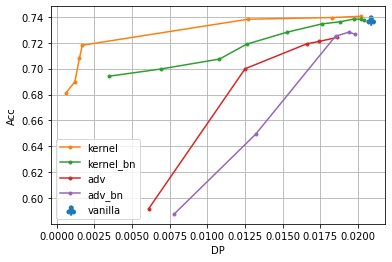

In [281]:
dataset = 'pokec_z'  ## 'pokec_n' 'pokec_z'
model = 'GCN' ## 'GAT', 'GCN'
method_vec = ['kernel', 'kernel_bn', 'adv', 'adv_bn']   ## 'kernel', 'kernel_bn', 'adv', 'adv_bn'
alpha_vec = [[0.0, 0.1, 0.3, 1.0, 3.0, 10.0, 50.0, 100.0],
            [0.0, 1.0, 3.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0, 2000.0],
            [0.0, 1.0, 10.0, 100.0, 500.0, 1000.0],
            [0.0, 1.0, 10.0, 50.0, 500.0, 2000.0]]
## kernel = [0.0, 1.0, 3.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0]
## adv = [0.0, 1.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 2000.0]

plot_tradeoff(method_vec, dataset, model, alpha_vec)

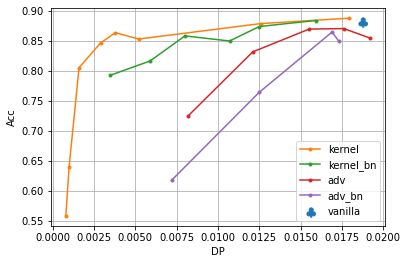

In [383]:
dataset = 'pokec_z'  ## 'pokec_n' 'pokec_z'
model = 'GAT' ## 'GAT', 'GCN', 'SGC'
method_vec = ['kernel', 'kernel_bn', 'adv', 'adv_bn']   ## 'kernel', 'kernel_bn', 'adv', 'adv_bn'
alpha_vec = [[0.0, 1.0, 3.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0],
            [0.0, 20.0, 50.0, 100.0, 200.0, 500.0, 1000.0],
            [0.0, 10.0, 50.0, 100.0, 500.0, 1500.0],
            [0.0, 10.0, 50.0, 500.0, 2000.0]]
## kernel = [0.0, 1.0, 3.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0]
## adv = [0.0, 1.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 2000.0]

plot_tradeoff(method_vec, dataset, model, alpha_vec)

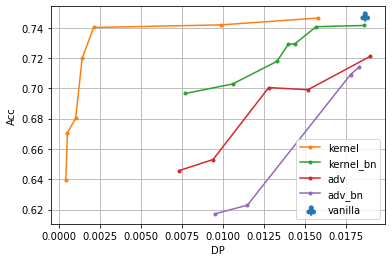

In [421]:
dataset = 'pokec_n'  ## 'pokec_n' 'pokec_z'
model = 'SGC' ## 'GAT', 'GCN'
method_vec = ['kernel', 'kernel_bn', 'adv', 'adv_bn']   ## 'kernel', 'kernel_bn', 'adv', 'adv_bn'
alpha_vec = [[0.0, 0.3, 1.0, 3.0, 10.0, 50.0, 100.0, 200.0],
            [0.0, 1.0, 10.0, 50.0, 100.0, 200.0, 500.0, 1000.0],
            [0.0, 1.0, 50.0, 100.0, 500.0, 1000.0],
            [0.0, 10.0, 50.0, 500.0, 1000.0]]
## kernel = [0.0, 1.0, 3.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0]
## adv = [0.0, 1.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 2000.0]

plot_tradeoff(method_vec, dataset, model, alpha_vec)

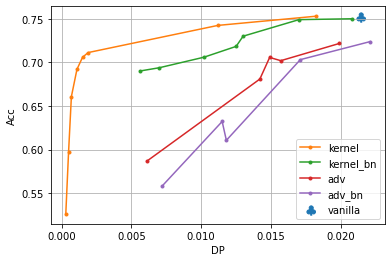

In [420]:
dataset = 'pokec_z'  ## 'pokec_n' 'pokec_z'
model = 'SGC' ## 'GAT', 'GCN'
method_vec = ['kernel', 'kernel_bn', 'adv', 'adv_bn']   ## 'kernel', 'kernel_bn', 'adv', 'adv_bn'
alpha_vec = [[0.0, 0.3, 1.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0],
            [0.0, 1.0, 20.0, 50.0, 100.0, 200.0, 500.0, 1000.0],
            [0.0, 3.0, 10.0, 50.0, 500.0, 1000.0],
            [0.0, 10.0, 50.0, 500.0, 1500.0, 1000.0]]
## kernel = [0.0, 1.0, 3.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0]
## adv = [0.0, 1.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 2000.0]

plot_tradeoff(method_vec, dataset, model, alpha_vec)

In [ ]:
# perfs, fairs = results_all(method_vec, dataset, model, alpha_vec)

# xaxis = fairs
# results = perfs
# labels = ['vanilla', 'kernel', 'kernel_bn', 'adv', 'adv_bn']
# xylabels = ['DP', 'Acc']
# title = f'{dataset}_{model}_tradeoff'
# path = 'results'

# plot_err(xaxis, results, labels, xylabels, title, path)